# Modelo clasificador de Tensorflow SpeechCommands

En lugar de utilizar librosa, utilizo la librería spectrogram.py <strong>"desarrollada"</strong>

In [1]:
print('Modelo clasificador de Tensorflow SpeechCommands.')

Modelo clasificador de Tensorflow SpeechCommands.


In [2]:
import numpy as np
from scipy.io import wavfile
import os
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt

In [3]:
# Cargado del dataset
import math
def create_dataset():
    y = []
    x = []
    #PATH = 'data/'
    #PATH = 'free_spoken_digit_dataset/recordings/'
    #PATH = 'Familia_SMNIST'
    #fs, _  = wavfile.read(os.path.join(PATH,os.listdir(PATH)[0]))
    fs = 5000


    data_dir = pathlib.Path('data/mini_speech_commands')
    if not data_dir.exists():
      tf.keras.utils.get_file(
          'mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True,
          cache_dir='.', cache_subdir='data')

    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    commands = np.delete(commands, np.where(commands=='yes')[0])
    commands = np.delete(commands, np.where(commands=='no')[0])
    commands = np.delete(commands, np.where(commands=='up')[0])

    print('Commands:', commands)

    for com in commands:
      for file_name in os.listdir(os.path.join(data_dir,com)):
        file_path = os.path.join(data_dir,com+'/'+file_name)
        data, _ = librosa.load(file_path, sr=fs)
        data = np.array(data)
        data = np.append(data,[0]*(fs-len(data)))
        
        y.append(np.where(commands==com)[0][0])
        x.append(data)
    
    y = np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
    
    return (x_train,y_train), (x_test,y_test), fs, commands


(x_train,y_train), (x_test,y_test), fs, commands= create_dataset()

182083584/182082353 [==============================] - 66s 0us/step
Commands: ['down' 'go' 'left' 'right' 'stop']


In [4]:
# Preprocesamiento de los datos
from spectrogram import create_spectrogram

n_mels = 32
n_fft = 256
noverlap = 0#n_fft//2
segundos = 1
largo = segundos*fs
bloques = largo // n_fft
print("bloques: ", bloques)
#bloques = largo//noverlap-1

def preprocess_data(x_train,x_test):
    mfcc_x_train = np.zeros((len(x_train),bloques,n_mels,1), dtype=np.float32)
    mfcc_x_test = np.zeros((len(x_test),bloques,n_mels,1), dtype=np.float32)

    print('Preparando train')
    for i_train in range(len(x_train)):
        dato = np.float32(x_train[i_train])
        starts,mfcc = create_spectrogram(dato,n_fft,n_mels,noverlap)
        #mfcc = librosa.power_to_db(mfcc)
        mfcc = np.reshape(mfcc, mfcc.shape + (1,))
        mfcc_x_train[i_train] = mfcc
                           
    print('Preparando test')
    for i_test in range(len(x_test)):
        dato = np.float32(x_test[i_test])
        starts,mfcc = create_spectrogram(dato,n_fft,n_mels,noverlap)
        #mfcc = librosa.power_to_db(mfcc)
        mfcc = np.reshape(mfcc, mfcc.shape + (1,))
        mfcc_x_test[i_test] = mfcc
    
    return mfcc_x_train , mfcc_x_test

mfcc_x_train,mfcc_x_test = preprocess_data(x_train,x_test)
print('mfcc_x_train.shape:', mfcc_x_train.shape)
print('mfcc_x_test.shape: ', mfcc_x_test.shape)

bloques:  19
Preparando train
Preparando test
mfcc_x_train.shape: (4000, 19, 32, 1)
mfcc_x_test.shape:  (1000, 19, 32, 1)


<function matplotlib.pyplot.show(*args, **kw)>

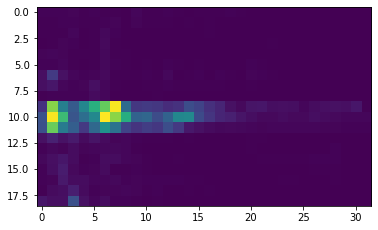

In [5]:
plt.imshow(mfcc_x_train[165,:,:,0])
plt.show

In [6]:
# Creación del modelo pequeño full convolucional
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.Conv2D(8,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.Conv2D(32,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32,kernel_size=(2, 2),activation='relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 30, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 28, 8)         296       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 14, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 13, 16)         528       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 12, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 6, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 5, 32)          4

In [7]:
# Creación del modelo grande
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.Conv2D(8,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 17, 30, 4)         40        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 28, 8)         296       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 26, 16)        1168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 6, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)              

In [8]:
# Creación del modelo mediano
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu',input_shape=mfcc_x_train[0].shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(commands.shape[0],activation='softmax')    
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 17, 30, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 15, 16)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 13, 32)         4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2885      
Total params: 7,685
Trainable params: 7,685
Non-trainable params: 0
____________________________________________________

In [9]:
# Entrenamiento del modelo
history = model.fit(mfcc_x_train,y_train,epochs=100,batch_size=64,validation_data=(mfcc_x_test,y_test),verbose=2)

Epoch 1/100
63/63 - 7s - loss: 1.4897 - acc: 0.3952 - val_loss: 1.3662 - val_acc: 0.5250
Epoch 2/100
63/63 - 1s - loss: 1.2858 - acc: 0.5468 - val_loss: 1.2315 - val_acc: 0.6270
Epoch 3/100
63/63 - 1s - loss: 1.1018 - acc: 0.6492 - val_loss: 1.0708 - val_acc: 0.7060
Epoch 4/100
63/63 - 1s - loss: 0.9643 - acc: 0.7013 - val_loss: 1.0046 - val_acc: 0.7320
Epoch 5/100
63/63 - 1s - loss: 0.8576 - acc: 0.7460 - val_loss: 0.9148 - val_acc: 0.7470
Epoch 6/100
63/63 - 1s - loss: 0.7667 - acc: 0.7788 - val_loss: 0.8213 - val_acc: 0.8000
Epoch 7/100
63/63 - 1s - loss: 0.7148 - acc: 0.7987 - val_loss: 0.7751 - val_acc: 0.8070
Epoch 8/100
63/63 - 1s - loss: 0.6652 - acc: 0.8102 - val_loss: 0.7643 - val_acc: 0.8120
Epoch 9/100
63/63 - 1s - loss: 0.6140 - acc: 0.8290 - val_loss: 0.7433 - val_acc: 0.8100
Epoch 10/100
63/63 - 1s - loss: 0.6029 - acc: 0.8280 - val_loss: 0.7911 - val_acc: 0.7790
Epoch 11/100
63/63 - 1s - loss: 0.5633 - acc: 0.8353 - val_loss: 0.7110 - val_acc: 0.8240
Epoch 12/100
63/63 

63/63 - 1s - loss: 0.1080 - acc: 0.9703 - val_loss: 1.2672 - val_acc: 0.8600
Epoch 93/100
63/63 - 1s - loss: 0.1072 - acc: 0.9700 - val_loss: 1.2729 - val_acc: 0.8610
Epoch 94/100
63/63 - 1s - loss: 0.1037 - acc: 0.9712 - val_loss: 1.2538 - val_acc: 0.8660
Epoch 95/100
63/63 - 1s - loss: 0.1015 - acc: 0.9705 - val_loss: 1.2777 - val_acc: 0.8680
Epoch 96/100
63/63 - 1s - loss: 0.1356 - acc: 0.9625 - val_loss: 1.4573 - val_acc: 0.8510
Epoch 97/100
63/63 - 1s - loss: 0.2898 - acc: 0.9212 - val_loss: 1.4853 - val_acc: 0.8180
Epoch 98/100
63/63 - 1s - loss: 0.1884 - acc: 0.9380 - val_loss: 1.3249 - val_acc: 0.8380
Epoch 99/100
63/63 - 1s - loss: 0.1501 - acc: 0.9528 - val_loss: 1.2577 - val_acc: 0.8560
Epoch 100/100
63/63 - 1s - loss: 0.1087 - acc: 0.9695 - val_loss: 1.2592 - val_acc: 0.8620


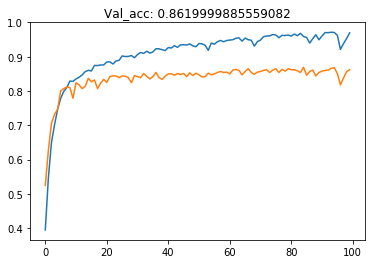

In [10]:
# Curvas accuracy
plt.title("Val_acc: "+str(history.history["val_acc"][-1]))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [11]:
# Exportar parámetros de espectrograma a C
inicio = ''
fmin = fmax = 0
step = n_fft - noverlap
len_nfft_nmels = (n_fft//2)//n_mels
print(f'''// Constantes autogeneradas: 

#ifndef {inicio}N_FFT
#define {inicio}N_MELS {n_mels}
#define {inicio}N_FFT {n_fft}
#define {inicio}N_FMIN {fmin}
#define {inicio}N_FMAX {fmax}
#define {inicio}FRAME_LENGTH {largo}
#define {inicio}SAMPLE_RATE {fs}
#define {inicio}BLOCKS {bloques}
#define {inicio}N_FFT_TABLE {int(n_fft/2)}
#define {inicio}NOVERLAP {noverlap}
#define {inicio}STEP {step}
#define {inicio}LEN_NFFT_NMELS {len_nfft_nmels}
#define {inicio}SPEC_SIZE {mfcc_x_test[0].flatten().shape[0]}
#define {inicio}DELAY_US {int(1/fs*1000*1000)}
#endif
''')


// Constantes autogeneradas: 

#ifndef N_FFT
#define N_MELS 32
#define N_FFT 256
#define N_FMIN 0
#define N_FMAX 0
#define FRAME_LENGTH 5000
#define SAMPLE_RATE 5000
#define BLOCKS 19
#define N_FFT_TABLE 128
#define NOVERLAP 0
#define STEP 256
#define LEN_NFFT_NMELS 4
#define SPEC_SIZE 608
#define DELAY_US 200
#endif



In [12]:
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)
np.save("mfcc_x_train.npy", mfcc_x_train)
np.save("mfcc_x_test.npy", mfcc_x_test)
model.save("model.h5")

# Recuperar modelo y datos

## Recuperar modelo, datos de prueba y entrenamiento

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('model.h5')
model.summary()
x_train = np.load('x_train.npy', allow_pickle=True)
mfcc_x_train = np.load('mfcc_x_train.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)

x_test = np.load('x_test.npy', allow_pickle=True)
mfcc_x_test = np.load('mfcc_x_test.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 15, 14, 8)         80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 4, 8)           0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 3, 16)          528       
_________________________________________________________________
flatten_15 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_41 (Dense)             (None, 10)                170       
Total params: 3,866
Trainable params: 3,866
Non-trainable params: 0
___________________________________________________

In [ ]:
model.evaluate(mfcc_x_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.6135 - acc: 0.8350


[0.6134818196296692, 0.8349999785423279]

## Recuperar un dato del test

In [23]:
import matplotlib.pyplot as plt
import numpy as np

dim_f = bloques
dim_c = n_mels

# Exportación a C
def imprimir_entrada(entrada):
    s=''
    for i in entrada:
        #i_string = f"{i}, "
        i_string = "%.7f, " % (i)
        s+=i_string
    print(f'float input_data[] = {{\n\t{s[:-2]}\n}};')

# Función que usamos siempre modificada
def visualizar_muestra(numero, repeticion, x_test, the_real_x_train, y_test, model, _imprimir_prediccion = 1, _imprimir_matriz = 0, _imprimir_vector = 0, _grafico_color = 0):
    '''
     Visualizar una muestra (imagen) e informacion adicional segun parametros
     Recibe: 
            numero: Número a buscar
            repeticion: Repetición dentro de x_test
            x_test, y_test: vectores de dataset de prueba
            model: necesario solo si _imprimir_prediccion = 1
    '''

    # Busqueda del número
    n_muestra = np.where(y_test==numero)[0][repeticion]
    muestra = x_test[n_muestra][:,:,:]

  # Visualización de datos
    if _imprimir_matriz:
        print('Matriz\n', muestra.reshape(dim_f,dim_c),'\n')

    if _imprimir_vector:
        #print('Arreglo\n', muestra.reshape(1,dim_f*dim_c),'\n')
        print("Arreglo\n")
        imprimir_entrada(the_real_x_train[n_muestra].flatten())

    muestra = np.reshape(muestra, (1,dim_f,dim_c,1))
    
    if _grafico_color:
        plt.imshow(muestra[0,:,:,0])
    else:
        plt.imshow(muestra[0,:,:,0], cmap='gray')

    if _imprimir_prediccion:
        plt.title(f"Clase: {commands[y_test[n_muestra]]} - Predicción: {commands[np.argmax(model.predict(np.reshape(x_test[n_muestra], ((1, )+ x_test[n_muestra].shape))))]}")
    else:
        plt.title(f"Clase: {commands[y_test[n_muestra]]}")
    
    plt.show()

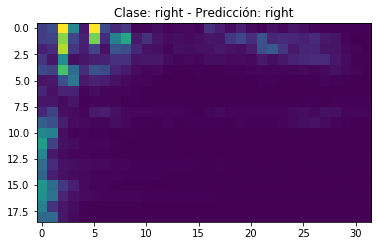

In [26]:
# Elección del número
numero = 3
repeticion = 1

# Qué datos adicionales imprimir
_imprimir_prediccion = 1
_imprimir_matriz = 0
_imprimir_vector = 0
_grafico_color = 1
visualizar_muestra(numero, repeticion, mfcc_x_test, x_test, y_test, model, _imprimir_prediccion, _imprimir_matriz, _imprimir_vector, _grafico_color)

# Datos a C para espectrogramizarlos

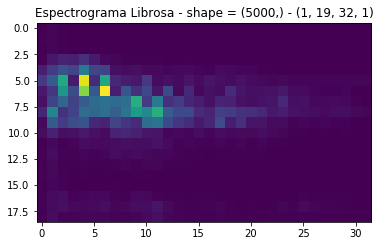

In [28]:
# Busqueda del número
numero = 2
repeticion = 5

# Graficar numero
n_muestra = np.where(y_test==numero)[0][repeticion]
muestra = x_test[n_muestra]
grafico_librosa = mfcc_x_test[n_muestra][:,:,:]
grafico_librosa = np.reshape(grafico_librosa, (1,dim_f,dim_c,1))
plt.imshow(grafico_librosa[0,:,:,0])
plt.title(f"Espectrograma Librosa - shape = {muestra.shape} - {grafico_librosa.shape}")
plt.show()

In [38]:
def dato_to_c(entrada):
    s=''
    for i in entrada:
        #i_string = f"{i}, "
        i_string = "%.7f, " % (i)
        s+=i_string
    #s+=f"{{s}}, \n\n"
    return s[:-2]

def save_to_file(filename, content):
    file = open(filename, 'w') #guardar
    file.write(content)
    file.close()    

filename = 'audio'
datos_en_c=f'float input_data[] = {{\n\t{dato_to_c(muestra)}\n}};'
save_to_file(filename+'.h', datos_en_c)

Todo terminó